## Описание проекта

Исходные данные:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72;
- `train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …). Вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов);
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv;
- `validation_answer.csv` - правильные ответы к предыдущему файлу.

Задачи:
- разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`;
- оценить качество алгоритма по метрике `accuracy@5`.

Метрика:
- необходимо максимизировать метрику ассигасу@5, которая для каждого объекта вычисляется по формуле:
                accuracy@5 = 100 * (кол-во верно определенных похожих объектов из 5 возможных / 5)

## Анализ данных

In [1]:
!pip install faiss-cpu
!pip install matplotlib

In [2]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import faiss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Прочтем датасеты
base_df = pd.read_csv('datasets/base.csv')
train_df = pd.read_csv('datasets/train.csv')
validation_df = pd.read_csv('datasets/validation.csv')
validation_answer_df = pd.read_csv('datasets/validation_answer.csv')

In [4]:
# Функция проссмотра информации о датафрейме
def show_df_info(df, label):
    display(label)
    display(df.head(5))
    display(df.describe())
    display(df.info())
    display(f'Количество дубликатов: {df.duplicated().sum()}')
    display(f'Общее количество NaN: {df.isna().sum().sum()}')

In [5]:
# Просмотрим информацию о датафрейме 'base_df'
show_df_info(base_df, 'base')

'base'

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
1,2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
2,1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3,3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
4,422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,...,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000
mean,-86.274741,8.078087,-44.613480,-146.605552,111.261183,-71.875015,-393.430460,20.391975,123.676692,124.427158,...,-79.075207,33.244836,-154.720293,13.699277,67.792659,23.543147,74.890028,115.611366,-798.355219,-47.701336
std,24.918947,4.949495,38.545928,19.842726,46.350083,28.189743,272.084921,64.297194,6.352832,64.366631,...,30.485074,28.896144,41.217568,98.996416,1.825081,55.353032,61.320347,21.219222,385.414338,41.731025
min,-189.356020,-12.594500,-231.785920,-224.880500,-95.240830,-188.473330,-791.468770,-296.171050,93.684616,-143.499600,...,-214.821140,-85.825500,-346.239320,-157.593866,59.835790,-213.492420,-190.483150,18.601448,-1297.924962,-209.935760
25%,-103.154300,4.709408,-69.535900,-159.882740,80.367640,-91.227936,-631.937855,-22.085905,119.473625,81.685610,...,-98.823830,16.952824,-180.695560,-71.763964,66.582790,-12.501141,33.784820,101.675660,-1074.464888,-75.621110
50%,-86.308130,8.040010,-43.838493,-146.717360,111.776870,-71.751820,-424.306925,20.850153,123.882500,123.456270,...,-78.538180,34.682540,-153.902830,13.167371,67.815050,23.461630,74.876980,116.049270,-1074.464888,-48.403816
75%,-69.254616,11.466815,-19.694052,-133.320140,142.364610,-52.310825,-157.342700,63.989326,127.967766,167.014130,...,-58.638412,52.097710,-127.221360,99.362213,69.028800,59.740337,115.896880,129.625950,-504.291183,-19.684170
max,15.574616,28.751917,151.377080,-55.167892,299.307920,49.880882,109.631986,301.094240,147.870910,402.994600,...,48.822197,141.025270,17.344528,185.096719,75.474625,264.347200,319.601040,213.577260,98.770811,126.973220


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291813 entries, 0 to 291812
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      291813 non-null  object 
 1   0       291813 non-null  float64
 2   1       291813 non-null  float64
 3   2       291813 non-null  float64
 4   3       291813 non-null  float64
 5   4       291813 non-null  float64
 6   5       291813 non-null  float64
 7   6       291813 non-null  float64
 8   7       291813 non-null  float64
 9   8       291813 non-null  float64
 10  9       291813 non-null  float64
 11  10      291813 non-null  float64
 12  11      291813 non-null  float64
 13  12      291813 non-null  float64
 14  13      291813 non-null  float64
 15  14      291813 non-null  float64
 16  15      291813 non-null  float64
 17  16      291813 non-null  float64
 18  17      291813 non-null  float64
 19  18      291813 non-null  float64
 20  19      291813 non-null  float64
 21  20      29

None

'Количество дубликатов: 11278'

'Общее количество NaN: 0'

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

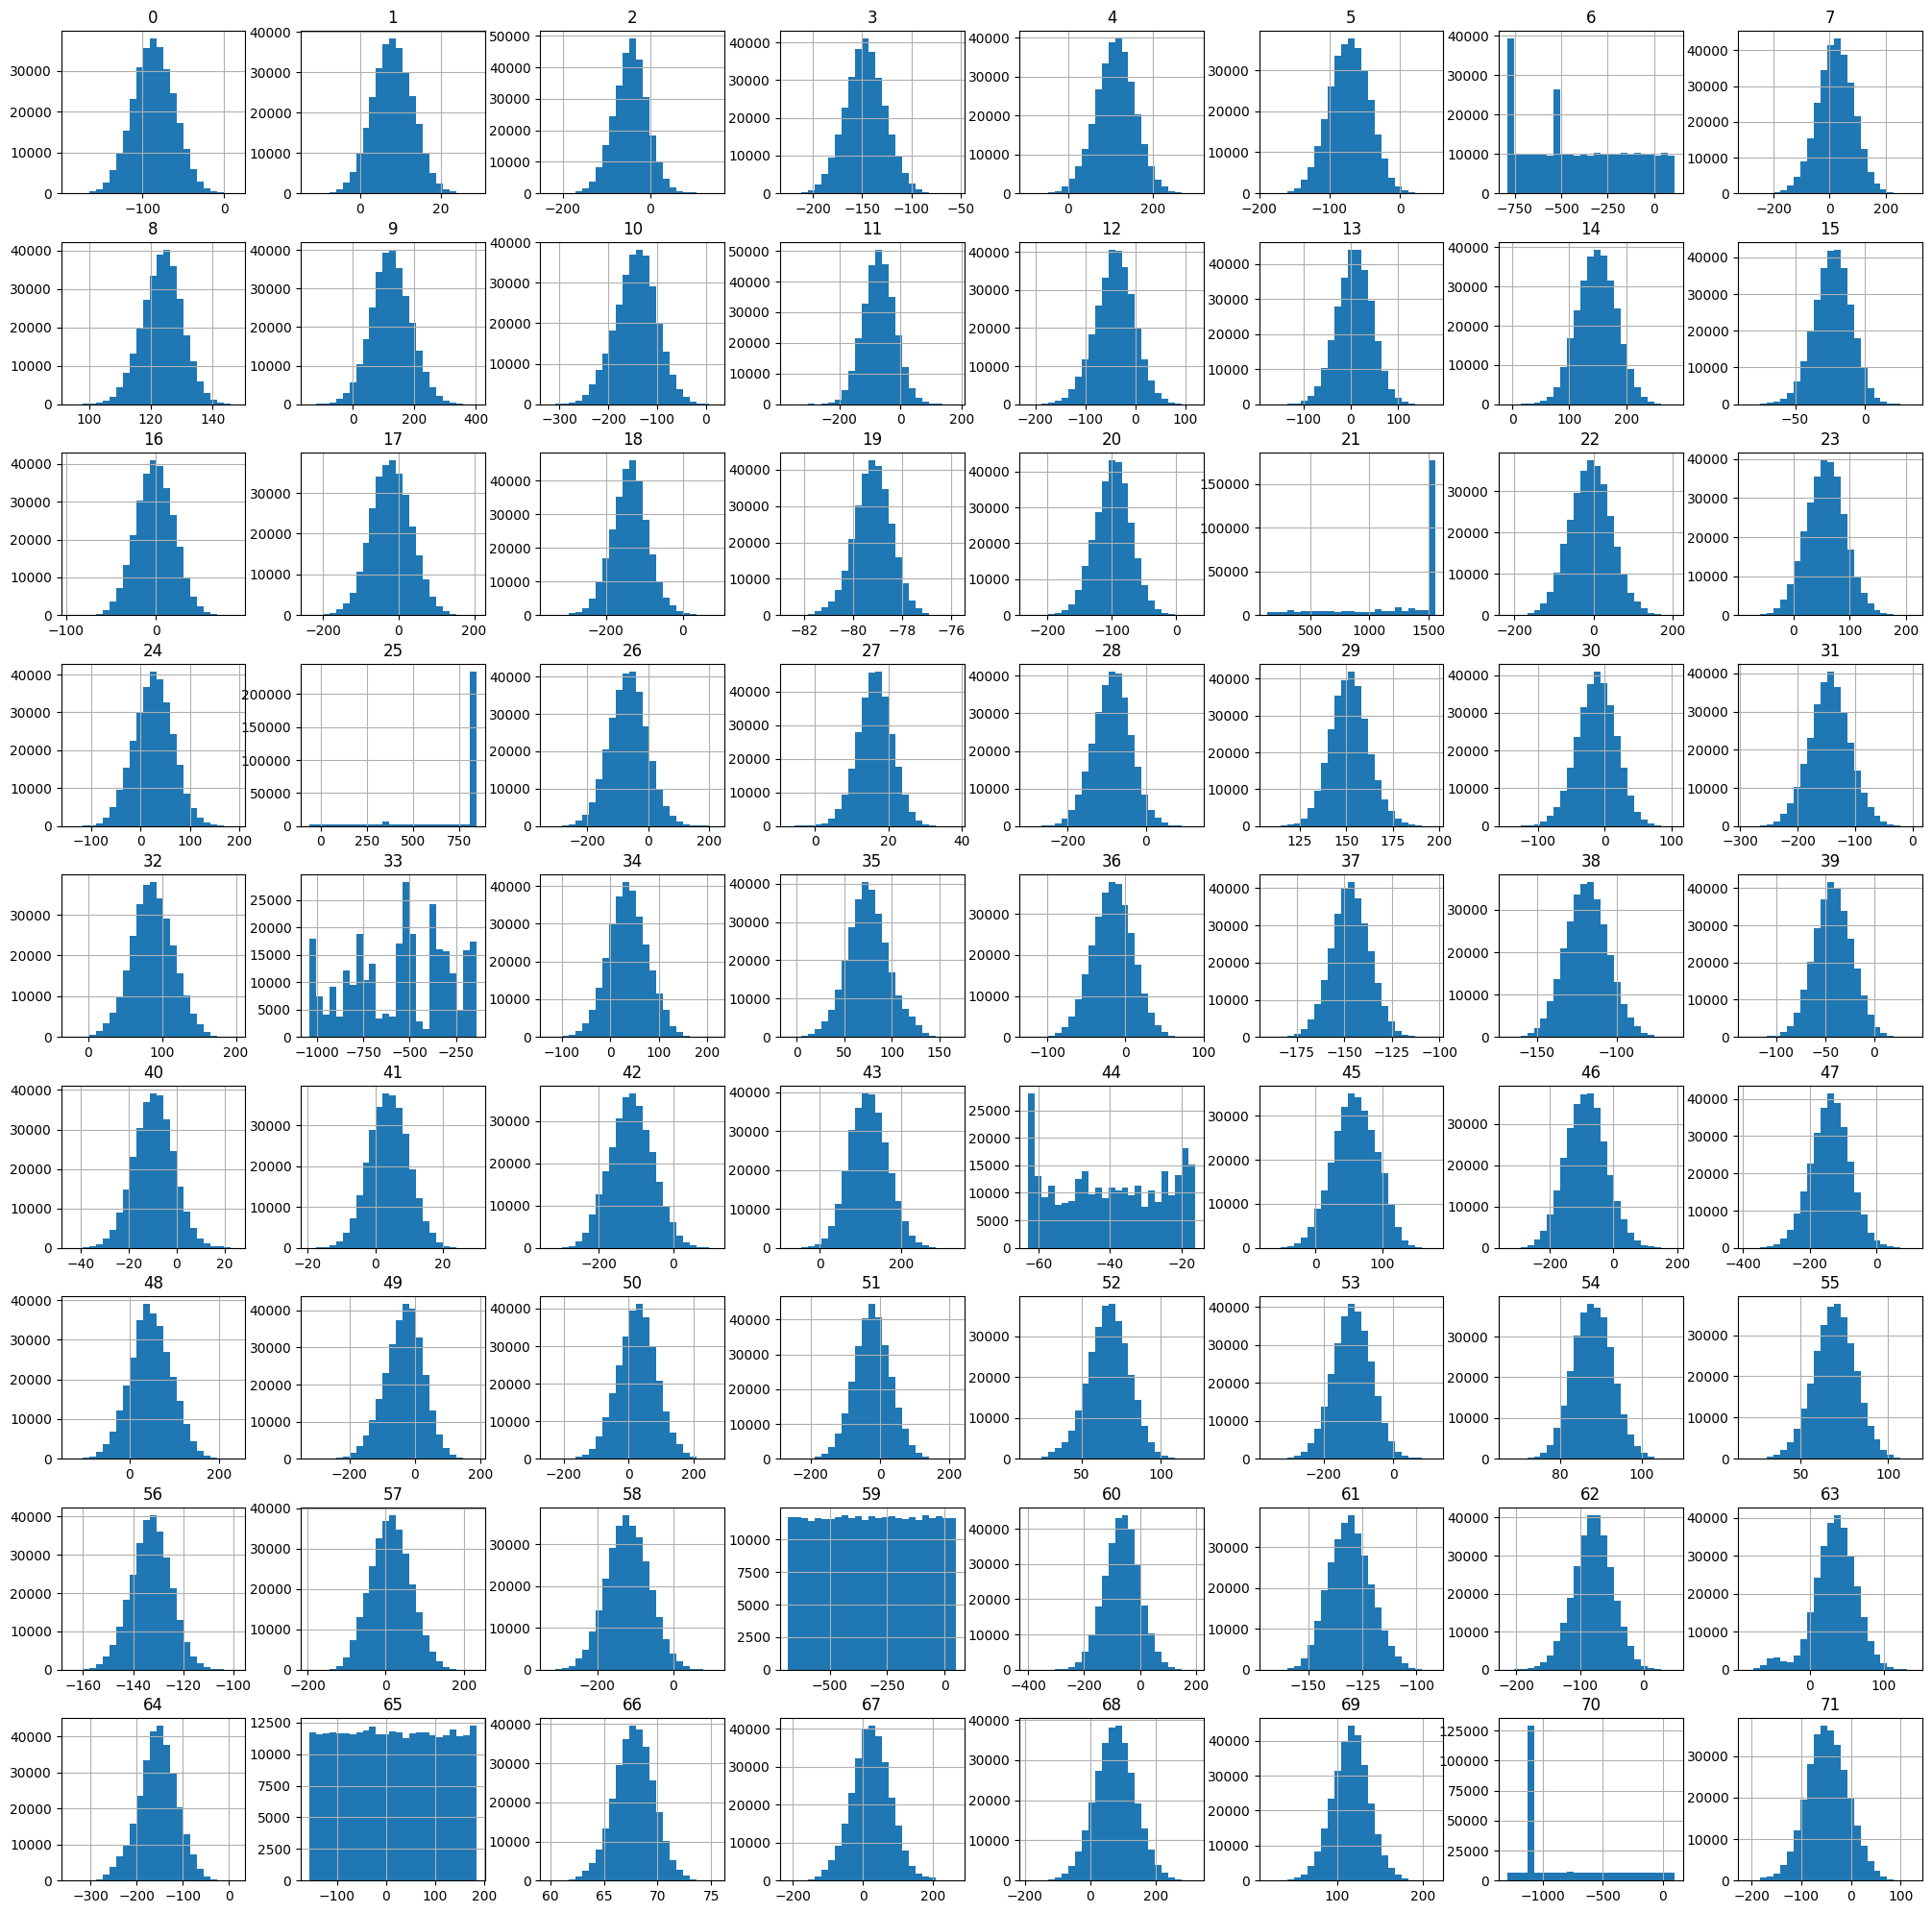

In [6]:
# Построим гистограмму для каждого признака для 'base_df'
base_df.hist(figsize=(25, 25), bins=25)

Вывод: по гистаграммам видно, что признаки 6, 21, 25, 33, 44, 59, 65, 70 не имеют нормального распределения. Проссмотрим их.

array([[<Axes: title={'center': '6'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '25'}>],
       [<Axes: title={'center': '33'}>, <Axes: title={'center': '44'}>,
        <Axes: title={'center': '59'}>],
       [<Axes: title={'center': '65'}>, <Axes: title={'center': '70'}>,
        <Axes: >]], dtype=object)

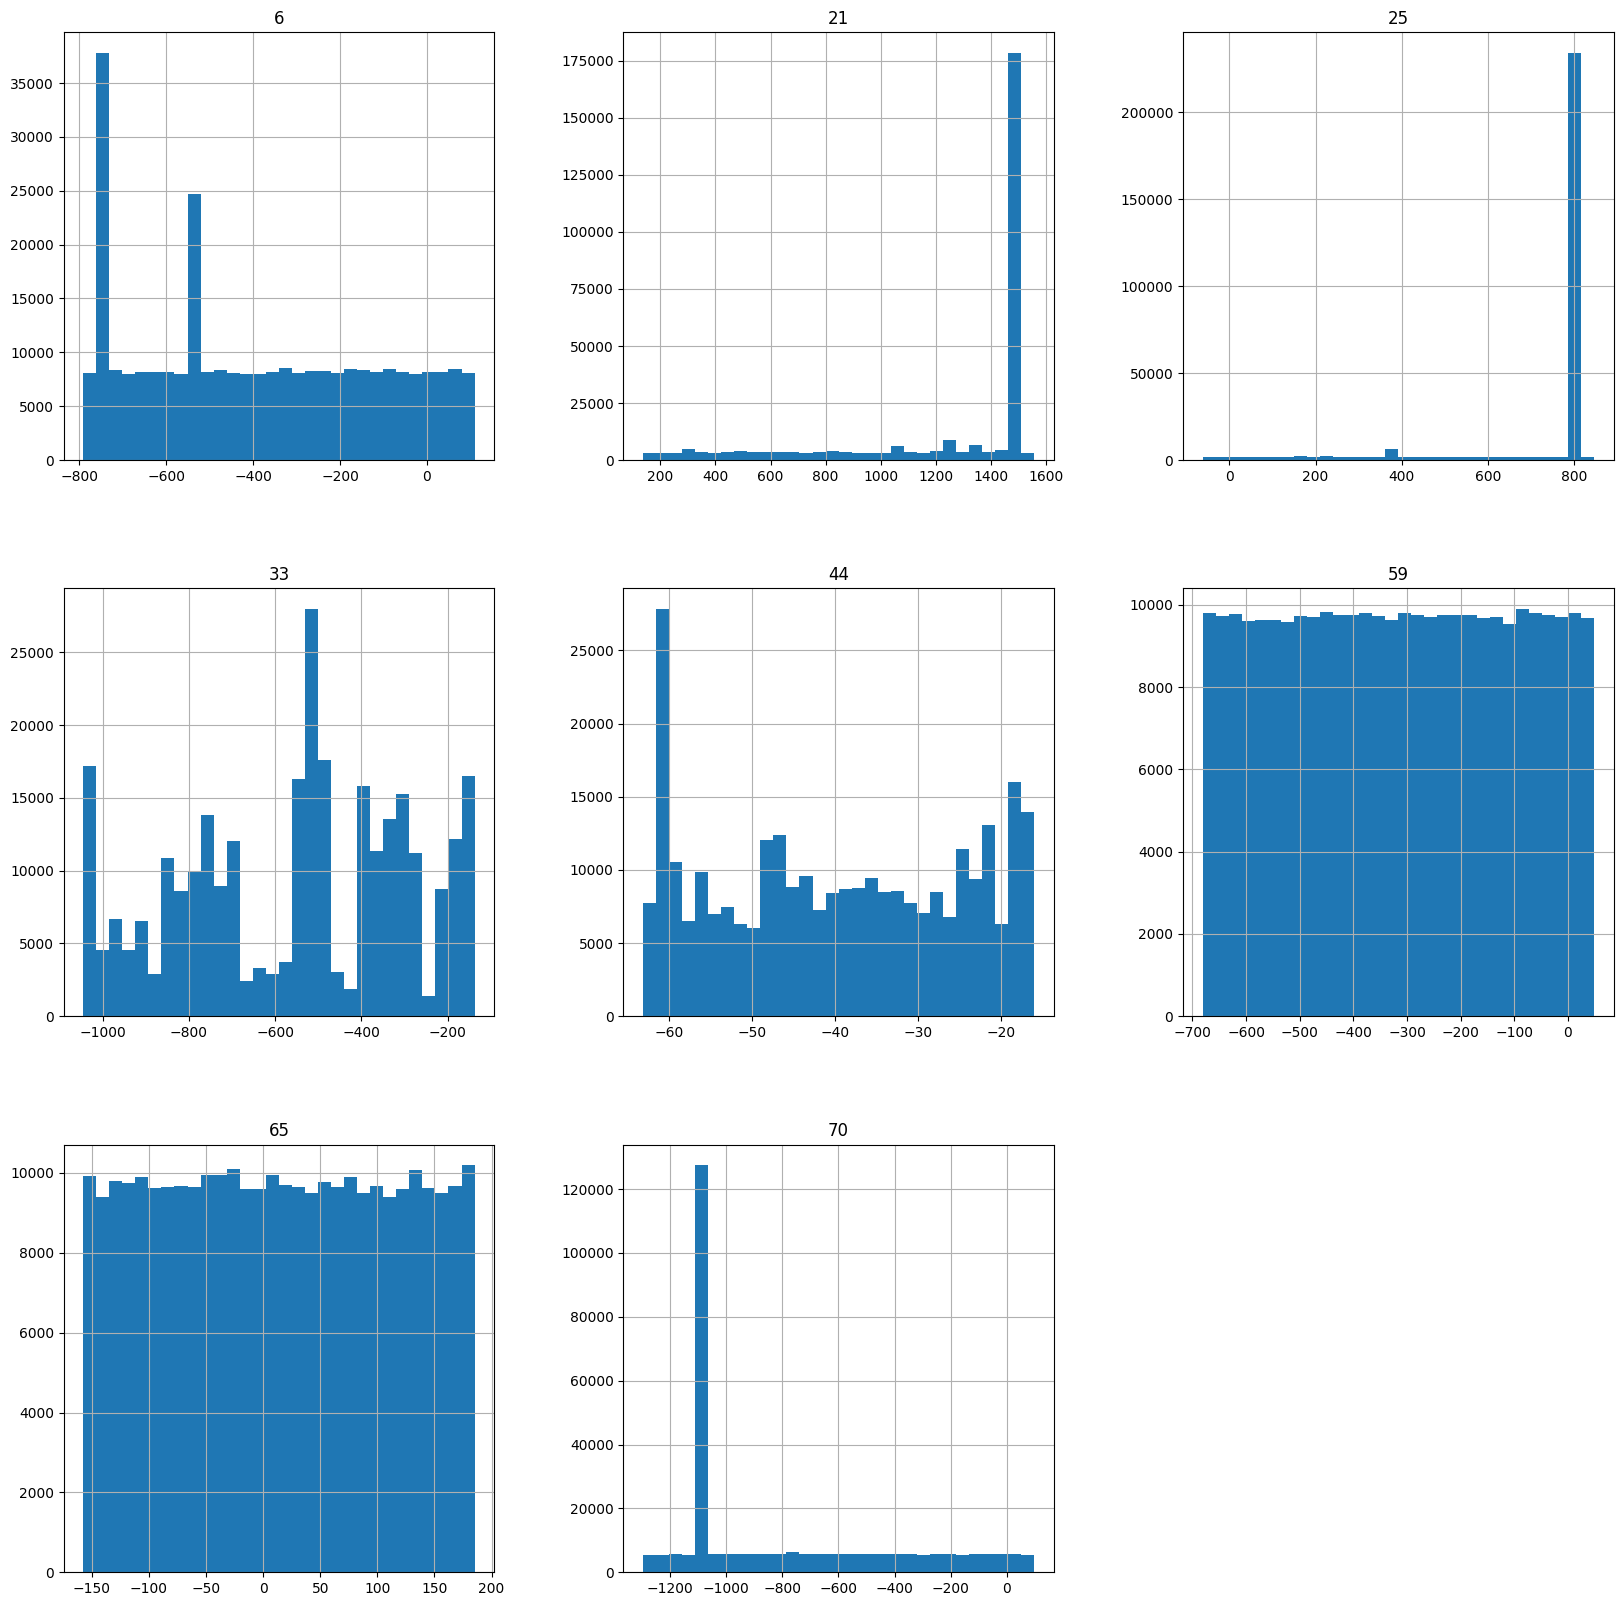

In [7]:
base_df[['6','21','25','33','44','59','65','70']].hist(figsize=(20, 20), bins=30)

Column:  6


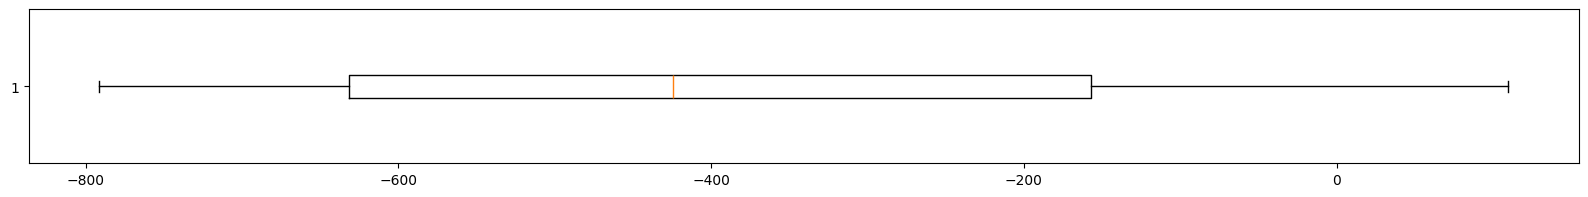

Column:  21


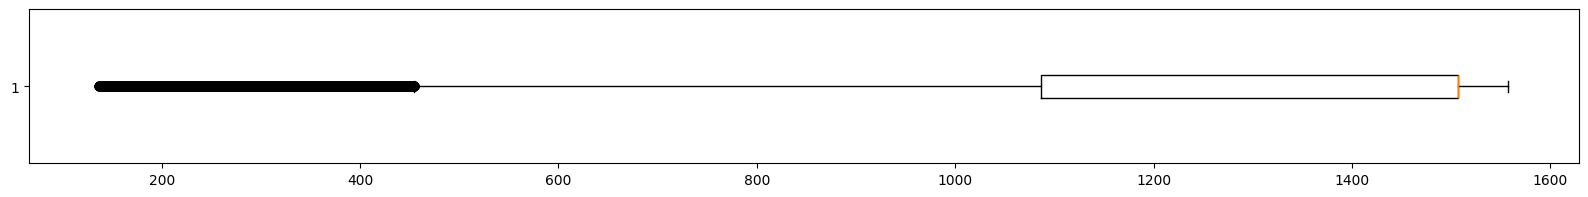

Column:  25


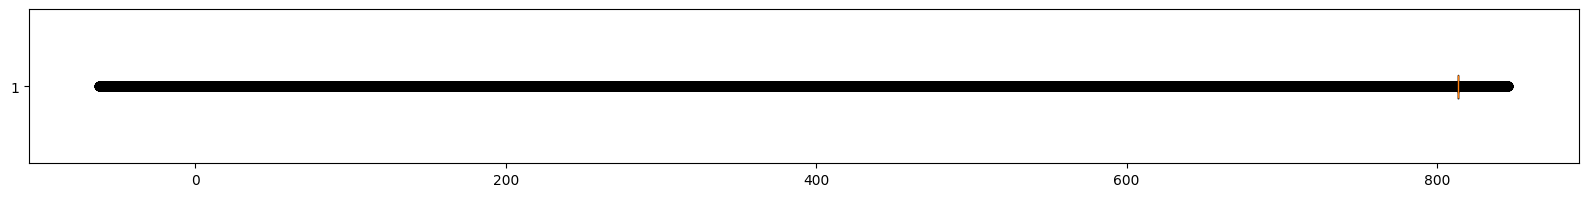

Column:  33


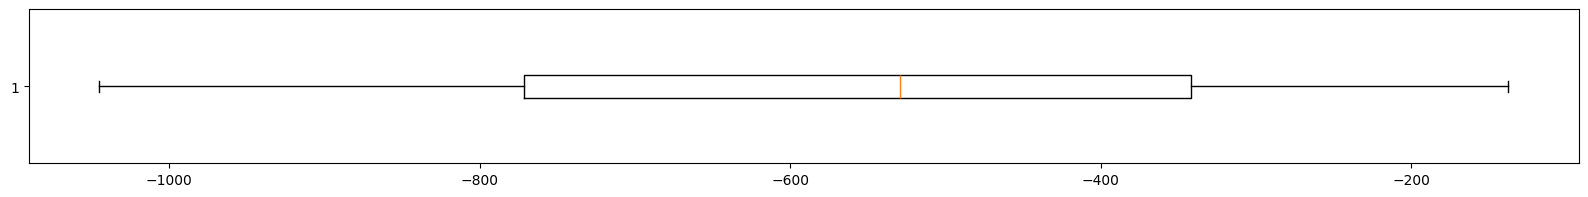

Column:  44


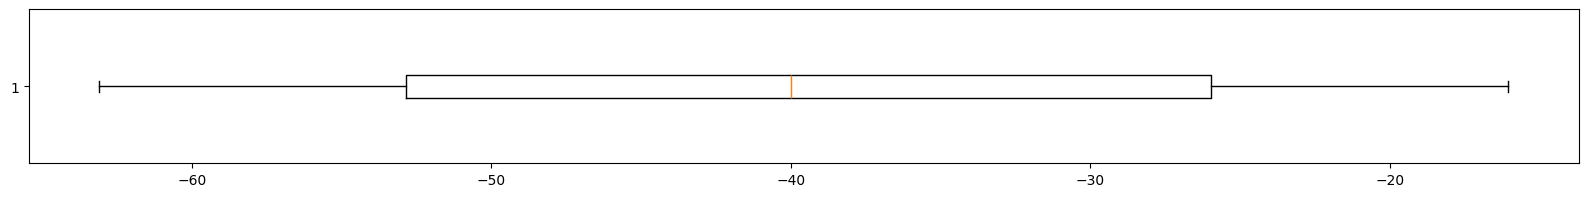

Column:  59


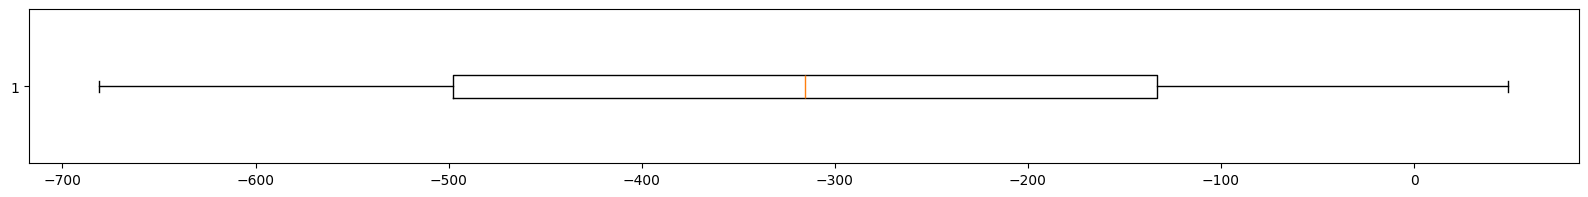

Column:  65


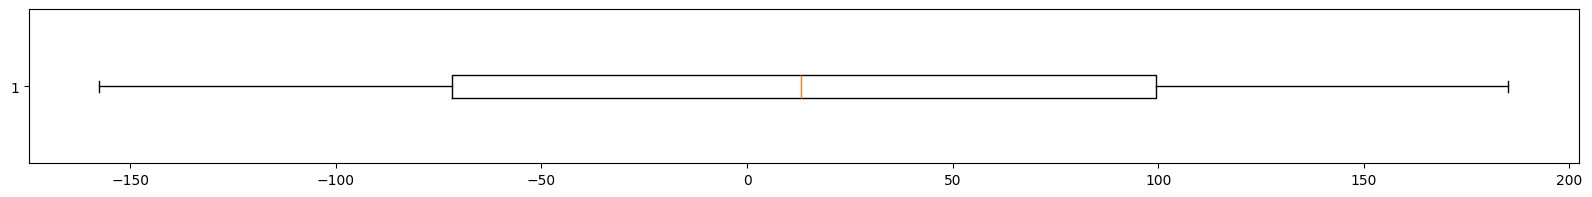

Column:  70


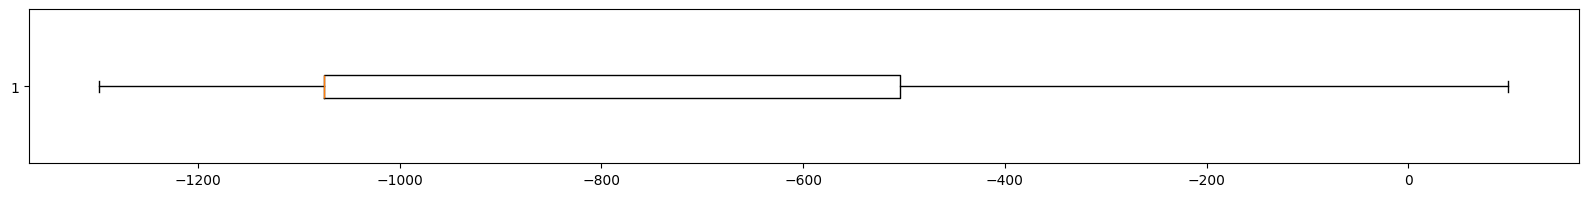

In [8]:
# Проверим на выбросы
for column in ['6','21','25','33','44','59','65','70']:
    print('Column: ', column)
    plt.figure(figsize=(20, 2))
    plt.boxplot(base_df[column], vert=False)
    plt.show()

Вывод: для признаков 21 и 25 имеются аномалии.

In [9]:
# Построим матрицу корреляций Пирсона
corr = base_df.drop('Id', axis=1).corr()
corr.style.background_gradient(cmap='Greens')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,-0.016414,0.028459,-0.018685,0.041892,-0.029893,0.002244,-0.003605,-0.001922,-0.005120,0.026633,0.010843,-0.020743,-0.024201,0.021481,-0.016379,-0.018850,-0.007852,0.009048,0.017472,0.034990,0.017143,0.028166,-0.046813,0.003723,0.041470,-0.010202,0.010541,-0.002073,-0.000860,-0.042099,-0.042299,-0.001152,0.032031,0.005447,-0.027167,0.034562,0.009798,-0.007843,-0.004091,0.032584,-0.029157,0.025581,0.017566,0.001502,0.037415,-0.007071,0.022068,-0.041532,-0.006872,0.001728,0.010288,0.047674,-0.022636,-0.016661,-0.013064,0.016673,0.061395,0.001328,-0.001749,-0.011924,0.037096,-0.020877,0.038106,0.012827,0.003083,0.001591,0.028330,-0.008323,-0.020754,-0.019486,0.022614
1,-0.016414,1.000000,0.002890,0.006965,-0.021119,0.031975,0.011845,0.045517,0.003118,-0.037306,-0.072928,-0.031682,-0.015201,0.028905,-0.054679,0.063351,0.063820,-0.039843,0.007059,-0.025068,-0.053538,0.030289,-0.071489,0.017000,0.059022,0.001385,-0.010412,-0.006213,0.025141,-0.053450,0.051550,0.005298,-0.047766,0.027388,-0.025942,0.095945,-0.056543,-0.040695,-0.001026,0.006487,-0.035893,-0.038933,-0.045050,-0.029686,0.069388,0.034794,0.000432,0.018721,0.066824,0.016206,0.004948,-0.001525,-0.007681,0.026020,0.009128,0.024496,-0.042278,-0.089310,-0.013659,-0.003260,-0.030433,-0.035839,0.010002,-0.142883,0.009036,0.001616,0.056413,0.009530,-0.018169,0.029173,-0.014196,-0.016389
2,0.028459,0.002890,1.000000,0.000766,0.003497,-0.050766,-0.000306,0.028169,0.004003,0.001489,0.009798,-0.014821,-0.024577,0.018330,-0.012170,0.012606,0.026540,0.036425,-0.000765,-0.006912,0.015631,0.041672,-0.042526,-0.030306,-0.013358,0.020626,-0.000984,0.008402,-0.005979,-0.027416,-0.011421,-0.020711,-0.010892,-0.015846,-0.035807,0.016907,-0.008349,-0.005393,0.010204,0.006748,-0.002332,-0.000077,0.006474,-0.022028,0.015924,0.027665,0.022340,-0.036705,0.045883,-0.026903,0.025367,-0.003869,0.039552,0.009645,0.016187,0.034916,0.007575,-0.009762,0.025326,-0.002024,-0.042248,-0.028823,-0.013907,0.017284,0.064558,0.000640,-0.025459,-0.001953,-0.037701,0.038977,0.009151,-0.042487
3,-0.018685,0.006965,0.000766,1.000000,-0.005115,-0.003480,0.000348,0.001860,-0.014832,-0.009899,0.025529,-0.010077,-0.017147,-0.011660,0.016817,-0.003163,0.020263,0.010582,0.015521,0.000347,-0.002110,-0.036170,0.038494,-0.003548,0.007173,-0.012549,0.004622,-0.023292,0.036107,0.013391,0.025553,0.016867,0.023664,-0.014285,0.037908,-0.008822,0.022089,0.017613,-0.013868,-0.012879,0.034853,-0.002350,0.028392,0.019441,-0.001342,-0.013185,0.014922,-0.007245,-0.024864,0.019305,-0.016015,-0.004151,-0.049274,0.000385,-0.017172,0.012660,-0.034906,0.031789,-0.021255,-0.000089,0.007017,-0.016478,-0.005867,0.020852,-0.001359,-0.001256,-0.030102,-0.001598,0.023280,0.008706,-0.009578,-0.004717
4,0.041892,-0.021119,0.003497,-0.005115,1.000000,0.014408,0.006488,-0.013775,-0.003119,0.016089,0.012326,-0.033075,0.006802,0.014120,0.002907,-0.027407,-0.019001,-0.004474,0.002584,-0.014391,0.002898,-0.001530,0.000801,-0.017401,-0.005916,0.017699,-0.020755,-0.004952,-0.021782,-0.016467,-0.002375,-0.037462,-0.025501,0.010787,-0.009817,-0.002878,0.022957,0.009906,0.018330,0.009924,0.004955,0.017176,-0.000640,-0.020536,0.004153,0.002247,-0.018240,-0.022826,-0.010486,-0.028404,-0.055918,0.021642,0.006406,0.026041,0.009840,0.019502,-0.018750,-0.017006,0.011129,0.001174,-0.005737,-0.020393,-0.013423,-0.006603,0.024194,0.005711,0.010125,0.022451,0.001013,-0.029567,-0.009222,0.042785
5,-0.029893,0.031975,-0.050766,-0.003480,0.014408,1.000000,-0.007138,0.003176,-0.014200,0.007223,-0.068525,-0.020892,0.004361,0.004676,-0.002747,0.079320,0.008510,-0.034480,0.028084,-0.041666,-0.037408,-0.042333,-0.050629,0.067657,-0.004672,0.000495,-0.018202,0.006982,-0.017350,-0.021346,0.022799,0.033242,-0.019886,0.013329,0.042188,0.066493,-0.080310,0.000557,-0

Вывод: по матрице видно, что сила связи варьируется от слабой отрицательной до слабой положительной.

In [10]:
# Просмотрим информацию о датафрейме 'train_df'
show_df_info(train_df, 'train')

'train'

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
1,34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
2,136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
3,105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
4,63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,-85.469569,7.608015,-43.886495,-146.204146,111.979577,-73.679417,-443.890756,21.820551,123.107400,126.418041,...,-81.373935,37.137381,-152.473803,16.533799,67.803505,23.750006,73.254974,115.410518,-708.824875,-48.325315
std,25.986217,4.985728,39.318615,20.309633,47.599872,28.743810,281.494323,66.450440,6.418815,64.858194,...,30.628554,25.391546,41.109706,98.956198,1.875665,54.838217,61.459193,21.641422,405.686503,40.899658
min,-173.032560,-11.560507,-187.292630,-219.724800,-71.243350,-184.962450,-791.443909,-250.681340,99.001770,-113.104600,...,-191.308230,-60.515068,-306.837650,-157.579209,61.339855,-165.361250,-127.017555,34.696030,-1297.871984,-208.276810
25%,-103.445763,4.178606,-69.990780,-160.032880,79.712390,-93.620305,-757.628755,-21.344349,118.787718,81.959692,...,-101.775513,20.369431,-179.337380,-67.498388,66.534668,-12.360923,32.034007,100.510068,-1074.464888,-75.271170
50%,-85.177100,7.592032,-43.009907,-146.576220,112.233475,-74.031080,-517.673347,22.233670,123.002785,126.280350,...,-81.767230,36.944336,-151.394590,16.007951,67.819710,24.146404,73.178340,115.813060,-800.296677,-49.027412
75%,-67.437850,10.989736,-17.223701,-132.675850,144.052645,-54.168713,-203.437622,66.437385,127.499309,169.959880,...,-60.619155,53.901959,-124.285235,101.773980,69.086705,59.301756,113.039340,130.225600,-362.486812,-21.845187
max,5.052292,26.741890,134.859800,-71.194680,297.368620,31.378914,109.632035,261.413420,145.178470,353.214970,...,20.978668,137.559200,-18.955208,185.055845,74.121605,236.385470,304.391780,187.621400,97.787799,111.831955


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      9999 non-null   object 
 1   0       9999 non-null   float64
 2   1       9999 non-null   float64
 3   2       9999 non-null   float64
 4   3       9999 non-null   float64
 5   4       9999 non-null   float64
 6   5       9999 non-null   float64
 7   6       9999 non-null   float64
 8   7       9999 non-null   float64
 9   8       9999 non-null   float64
 10  9       9999 non-null   float64
 11  10      9999 non-null   float64
 12  11      9999 non-null   float64
 13  12      9999 non-null   float64
 14  13      9999 non-null   float64
 15  14      9999 non-null   float64
 16  15      9999 non-null   float64
 17  16      9999 non-null   float64
 18  17      9999 non-null   float64
 19  18      9999 non-null   float64
 20  19      9999 non-null   float64
 21  20      9999 non-null   float64
 22  

None

'Количество дубликатов: 243'

'Общее количество NaN: 0'

In [11]:
# Просмотрим информацию о датафрейме 'validation_df'
show_df_info(validation_df, 'validation')

'validation'

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,...,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
1,134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,...,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
2,82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,...,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
3,162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,...,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
4,23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,...,-116.440605,47.279976,-162.65400,107.409409,67.78526,-60.976490,142.68571,82.264300,-345.340457,-48.572525


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-85.307362,7.633750,-43.686537,-146.038791,111.209942,-72.767940,-440.587163,21.834861,123.051767,124.662559,...,-81.250167,36.956902,-152.122730,14.886141,67.791824,22.857614,72.524486,115.420796,-709.333484,-49.022258
std,25.911681,4.950078,38.805284,20.543489,47.779448,28.617899,278.953671,66.326518,6.522882,65.458934,...,30.617505,25.251097,40.945219,99.384247,1.851120,55.658492,62.595136,21.490729,405.917480,41.159872
min,-167.550670,-10.583933,-205.797360,-219.720890,-76.422760,-170.868380,-791.443909,-277.983950,97.360535,-118.700714,...,-189.231300,-47.206474,-308.200380,-157.580677,61.086390,-174.799100,-159.840730,27.746750,-1297.689518,-209.935760
25%,-103.253996,4.245802,-69.606605,-159.972975,78.592808,-92.371089,-739.549115,-22.112910,118.623887,81.167942,...,-101.935440,19.950575,-178.986322,-71.481630,66.545755,-14.034864,31.120448,100.431221,-1074.464888,-76.834515
50%,-85.495230,7.604729,-43.152172,-146.100195,111.398595,-72.734217,-512.600719,22.596903,123.105532,124.588370,...,-80.640330,36.343388,-151.159155,16.498258,67.809390,22.756214,71.640040,115.465535,-809.193143,-49.420510
75%,-67.228041,10.950509,-17.883776,-131.973093,143.645965,-53.415469,-204.531443,67.179237,127.583330,168.550240,...,-60.179952,53.856120,-124.446027,100.077341,69.043971,60.188393,114.197410,129.996610,-358.197327,-20.995152
max,10.861183,27.944784,107.040690,-73.909584,287.397200,47.001106,109.404851,251.090180,146.034410,350.088320,...,31.880241,141.025270,-17.406784,184.987267,73.886790,241.695620,289.583160,190.171420,98.747128,102.473755


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      10000 non-null  object 
 1   0       10000 non-null  float64
 2   1       10000 non-null  float64
 3   2       10000 non-null  float64
 4   3       10000 non-null  float64
 5   4       10000 non-null  float64
 6   5       10000 non-null  float64
 7   6       10000 non-null  float64
 8   7       10000 non-null  float64
 9   8       10000 non-null  float64
 10  9       10000 non-null  float64
 11  10      10000 non-null  float64
 12  11      10000 non-null  float64
 13  12      10000 non-null  float64
 14  13      10000 non-null  float64
 15  14      10000 non-null  float64
 16  15      10000 non-null  float64
 17  16      10000 non-null  float64
 18  17      10000 non-null  float64
 19  18      10000 non-null  float64
 20  19      10000 non-null  float64
 21  20      10000 non-null  float64
 22 

None

'Количество дубликатов: 265'

'Общее количество NaN: 0'

In [12]:
# Просмотрим информацию о датафрейме 'validation_answer_df'
show_df_info(validation_answer_df, 'validation_answer')

'validation_answer'

,Id,Expected
0,196680-query,1087368-base
1,134615-query,849674-base
2,82675-query,4183486-base
3,162076-query,2879258-base
4,23069-query,615229-base


,Id,Expected
count,10000,10000
unique,9735,9640
top,195658-query,935520-base
freq,3,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        10000 non-null  object
 1   Expected  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


None

'Количество дубликатов: 265'

'Общее количество NaN: 0'

## Оценка качества для базовой модели 

In [13]:
# Отделим id и векторы признаков
base_ids = base_df.iloc[:, 0].values
base_features = base_df.iloc[:, 1:].values

train_ids = train_df.iloc[:, 0].values
train_features = train_df.iloc[:, 1:-1].values
train_base_ids = train_df.iloc[:, -1]

validation_ids = validation_df.iloc[:, 0].values
validation_features = validation_df.iloc[:, 1:].values

validation_answer_ids = validation_answer_df.iloc[:, 1].values

In [14]:
# Создадим индекс
dim = base_features.shape[1]
index = faiss.IndexFlatL2(dim)

In [15]:
# Обучим индекс на base_features
index.add(base_features)

In [16]:
# Найдем ближайших соседей
distances, indices = index.search(validation_features, 5)

In [17]:
# Преобразуем индексы в id из base
validation_predictions = base_ids[indices]

In [18]:
# Функция для расчета accuracy@5
def accuracy_at_5(predictions, true_ids):
    correct_predictions = 0
    for i, true_id in enumerate(true_ids):
        if true_id in predictions[i]:
            correct_predictions += 1
    return 100 * (correct_predictions / len(true_ids))

In [19]:
accuracy = accuracy_at_5(validation_predictions, validation_answer_ids)
print(f'Accuracy@5 для базовой модели: {accuracy:.2f}%')

Accuracy@5 для базовой модели: 16.74%


## Обучение моделей

In [20]:
# Кодируем метки классов
le = LabelEncoder()
train_base_ids_encoded = le.fit_transform(train_base_ids)

In [21]:
# Промасштабируем данные
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
validation_features_scaled = scaler.transform(validation_features)
base_features_scaled = scaler.transform(base_features)

In [22]:
# Применим PCA
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features_scaled)
validation_features_pca = pca.transform(validation_features_scaled)
base_features_pca = pca.transform(base_features_scaled)

In [23]:
# Создадим и обучим 'Логистическую регрессию'
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features_pca, train_base_ids_encoded)

LogisticRegression(max_iter=1000)

In [24]:
# Создадим и обучим 'Деревья решений'
dt = DecisionTreeClassifier(max_depth=15)
dt.fit(train_features_pca, train_base_ids_encoded)

DecisionTreeClassifier(max_depth=15)

In [25]:
# Создадим и обучим 'Случайный лес'
rf = RandomForestClassifier(n_estimators=50, max_depth=15)
rf.fit(train_features_pca, train_base_ids_encoded)

RandomForestClassifier(max_depth=15, n_estimators=50)

In [26]:
# Функция для получения top-5 предсказаний
def get_top_5_predictions(model, features, le):
    probabilities = model.predict_proba(features)
    top_5_indices = np.argsort(probabilities, axis=1)[:, -5:][:, ::-1]
    top_5_predictions = np.array([le.inverse_transform(indices) for indices in top_5_indices])
    return top_5_predictions

In [27]:
# Получаем предсказания для каждой модели
log_reg_predictions = get_top_5_predictions(log_reg, validation_features_pca, le)
rf_predictions = get_top_5_predictions(rf, validation_features_pca, le)
dt_predictions = get_top_5_predictions(dt, validation_features_pca, le)

In [28]:
# Оцениваем модели
log_reg_accuracy = accuracy_at_5(log_reg_predictions, validation_answer_ids)
rf_accuracy = accuracy_at_5(rf_predictions, validation_answer_ids)
dt_accuracy = accuracy_at_5(dt_predictions, validation_answer_ids)

print(f'Logistic Regression Accuracy@5: {log_reg_accuracy:.2f}%')
print(f'Random Forest Accuracy@5: {rf_accuracy:.2f}%')
print(f'Decision Tree Accuracy@5: {dt_accuracy:.2f}%')

Logistic Regression Accuracy@5: 6.63%
Random Forest Accuracy@5: 0.66%
Decision Tree Accuracy@5: 0.05%


Вывод:
- В данной работе использовалась Faiss библиотека для поиска ближайших соседей.
- На валидацинной выборке базовая модель показала метрику accuracy@5 равную 16.74%
- Было выполнено:
  - кодирование меток;
  - масштабирование данных;
  - применение РСА;
- Создали и обучили Случайный лес значение 0.66%, Логистическую регрессию - 6.63%, Дерево решений - 0.05%.